In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

Using TensorFlow backend.


In [2]:
data = pd.read_csv('./Sentiment.csv')
data = data[['text','sentiment']]

In [3]:
data = data[data.sentiment != "Neutral"]
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
data = data.reset_index(drop=True)

pos = len(data[ data['sentiment'] == 'Positive'])
neg = len(data[ data['sentiment'] == 'Negative'])
print(pos)
print(neg)

2236
8493


In [4]:
#Equalizing positive and negative tweets
neglist=[]
for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')
    if row[1]=='Negative':
        neglist.append(idx)

for i in neglist[pos:]:
    data=data.drop(i)
    
pos = len(data[ data['sentiment'] == 'Positive'])
neg = len(data[ data['sentiment'] == 'Negative'])

print(pos)
print(neg)

2236
2236


In [5]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X,maxlen=28)

In [6]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 28, 128)           256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 28, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.4, random_state = 42)
print(len(X_train),len(Y_train))
print(len(X_test),len(Y_test))

2683 2683
1789 1789


In [8]:
validation_size = 789

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]

In [9]:
batch_size = 32
hist = model.fit(X_train, Y_train, validation_data=(X_validate,Y_validate),
          callbacks=[EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')],
          epochs = 15, batch_size=batch_size, verbose = 1)

Train on 2683 samples, validate on 789 samples
Epoch 1/15
2683/2683 [==============================] - 11s 4ms/step - loss: 0.5686 - acc: 0.6858 - val_loss: 0.4343 - val_acc: 0.8074
Epoch 2/15
2683/2683 [==============================] - 6s 2ms/step - loss: 0.3610 - acc: 0.8375 - val_loss: 0.4219 - val_acc: 0.8390
Epoch 3/15
2683/2683 [==============================] - 6s 2ms/step - loss: 0.2630 - acc: 0.8949 - val_loss: 0.4868 - val_acc: 0.8074
Epoch 4/15
2683/2683 [==============================] - 6s 2ms/step - loss: 0.2024 - acc: 0.9221 - val_loss: 0.4975 - val_acc: 0.7782
Epoch 5/15
2683/2683 [==============================] - 6s 2ms/step - loss: 0.1551 - acc: 0.9411 - val_loss: 0.6001 - val_acc: 0.8061
Epoch 00005: early stopping


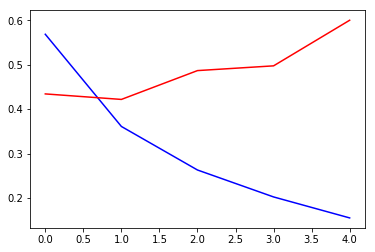

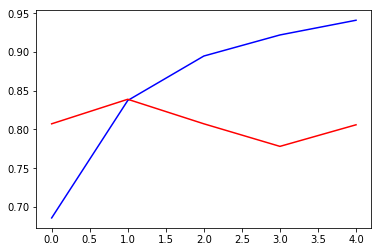

In [10]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [11]:
score,acc = model.evaluate(X_test, Y_test, verbose = 1, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

1000/1000 [==============================] - 1s 909us/step
score: 0.66
acc: 0.80


In [12]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_test)):
    
    result = model.predict(X_test[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_test[x]):
        if np.argmax(Y_test[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_test[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

pos_acc 76.74418604651163 %
neg_acc 81.97343453510436 %


In [13]:
import random
ran = random.randint(1,1000)
twt = data['text'][ran]
sent = data['sentiment'][ran]
print(twt)
print(sent)
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("Negative")
elif (np.argmax(sentiment) == 1):
    print("Positive")

regardless of who won the gopdebate it was clear that womens rights lost standwithpp prochoice  httpstcomcems58r9i
Negative
[[   0    0    0 ...    0    0  785]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0  117]
 ...
 [   0    0    0 ...    0    0  785]
 [   0    0    0 ...    0    0 1138]
 [   0    0    0 ...    0    0    7]]
Negative
